In [4]:
#Lindsey Staples
#Point Cloud Segmentation and a Visual Display Output of .ply files

import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import open3d as o3d
from mpl_toolkits import mplot3d
from sklearn.metrics import confusion_matrix
#import itertools
import plotly.graph_objects as go
import detectron2
from detectron2.utils.visualizer import Visualizer
import torch
from path import Path


tf.random.set_seed(1234)

In [5]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

In [6]:
ply = open("./LcatLroom.ply")

In [7]:
mesh = trimesh.load("LcatLroom.ply")
#mesh.show()

In [8]:
cloud = o3d.io.read_point_cloud('LcatLroom.ply')
#cloud = o3d.io.read_point_cloud('cargo_hauler.ply')
#cloud = o3d.io.read_point_cloud('chair.ply')
points = np.asarray(cloud.points)

colors = None
if cloud.has_colors():
    colors = np.asarray(cloud.colors)
elif cloud.has_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(cloud.normals) * 0.5
else:
    geometry.paint_uniform_color((1.0, 0.0, 0.0))
    colors = np.asarray(geometry.colors)

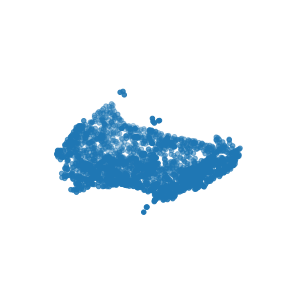

In [9]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

In [10]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [11]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [12]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)


In [13]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [14]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

In [15]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [16]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 32)     128         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 2048, 32)     0           ['batch_normalization[0][0

In [17]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
98/98 [==============================] - 206s 2s/step - loss: 3.3091 - sparse_categorical_accuracy: 0.3503 - val_loss: 12855436288.0000 - val_sparse_categorical_accuracy: 0.2956
Epoch 2/10
98/98 [==============================] - 202s 2s/step - loss: 2.6874 - sparse_categorical_accuracy: 0.4786 - val_loss: 7.2226 - val_sparse_categorical_accuracy: 0.2909
Epoch 3/10
98/98 [==============================] - 206s 2s/step - loss: 2.4625 - sparse_categorical_accuracy: 0.5688 - val_loss: 1225819.0000 - val_sparse_categorical_accuracy: 0.4088
Epoch 4/10
98/98 [==============================] - 202s 2s/step - loss: 2.3295 - sparse_categorical_accuracy: 0.6366 - val_loss: 11846145802240.0000 - val_sparse_categorical_accuracy: 0.6164
Epoch 5/10
98/98 [==============================] - 205s 2s/step - loss: 2.1992 - sparse_categorical_accuracy: 0.6743 - val_loss: 3794978210727094910976.0000 - val_sparse_categorical_accuracy: 0.6289
Epoch 6/10
98/98 [==============================] - 200

In [18]:
#import cv2
#im = fig.show("./LcatLroom.ply")
#v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#out = v.draw_instance_predictions(outputs["instances"])
#cv2.imshow(out.get_image()[:, :, ::-1])

In [31]:
print("Train Points")
print(np.array(train_points))
print(" ")
print("Test Points")
print(np.array(test_points))
print(" ")
print("Train Labels")
print(np.array(train_labels))
print(" ")
print("Test Labels")
print(np.array(test_labels))

Train Points
[[[ 1.33265077e+01  1.90521478e+00  6.24852432e+00]
  [ 1.85012000e+01 -2.82983509e+01 -9.67852389e+00]
  [ 1.85012000e+01 -1.57755739e+01 -8.57022272e+00]
  ...
  [ 7.19271347e+00  2.39750000e+01  1.11853287e+00]
  [ 1.85012000e+01  1.83046871e+01  7.48263933e+00]
  [ 1.85012000e+01 -2.42459853e-01 -8.20167530e+00]]

 [[-2.75211244e+00  2.35696434e+01 -2.75528784e+00]
  [-1.34029473e+01  2.39926628e+00 -4.78500709e+00]
  [ 3.04688248e+00 -1.28712594e+01  9.62500000e+00]
  ...
  [ 5.38912166e+00 -2.15465457e+00 -1.13750000e+01]
  [-1.07761038e+01  1.40035953e+01 -4.32596105e-01]
  [ 3.52771255e+00 -2.43326785e+01 -2.34534234e+00]]

 [[ 1.85581511e+00  3.18125573e+01  1.05708950e+01]
  [-7.80677619e-01  3.25716615e+01  7.81550931e+00]
  [ 9.47779042e+00  1.47696524e+01 -5.17524099e+00]
  ...
  [ 1.37795500e+01  1.67647360e+01  1.03908936e+01]
  [ 1.37795500e+01  2.04003670e+01  6.66288602e+00]
  [-1.10236400e+01  2.67896155e+01  1.16982099e+00]]

 ...

 [[ 7.85364305e+00  6

In [1]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

torch.save(model.save('./model.pth'))

NameError: name 'test_dataset' is not defined

In [35]:
print("Points")
#print(preds[i])
print(points)
print(" ")
print("Labels")
print(labels)
print(" ")
print("Predictions")
print(preds)

Points
[[[ 6.54781201e-01  9.83443079e+00  1.47285556e+01]
  [ 5.35444597e-01 -1.33554643e+01  1.41325624e+00]
  [-1.73427500e+00  1.43100000e+01  9.83741312e+00]
  ...
  [ 1.46477016e+00  6.48351371e+00 -6.90829587e+00]
  [-5.22308377e-01 -7.98641122e-01  3.59551884e+00]
  [-8.47863060e-01  1.28616396e+00 -9.63536647e+00]]

 [[ 2.84282645e+00 -9.45949940e-01  2.04991326e+00]
  [ 6.73558291e+00  9.63766915e+00  1.58152897e+01]
  [-7.85481928e+00  7.75192940e+00  8.13115356e+00]
  ...
  [-8.82134078e+00 -7.42714089e+00  2.52425179e+00]
  [-1.12530820e+00 -2.33597067e+00  2.10875690e+00]
  [-7.13581162e+00  7.61870710e+00  1.03651236e+01]]

 [[-1.20978960e+00  5.26117112e+00  1.21250000e+01]
  [ 1.38838979e-01  5.46571323e-01  3.75000000e+00]
  [ 4.14298615e-02  7.31250000e+00  2.49521787e-01]
  ...
  [ 1.78138535e-01  7.31250000e+00  3.94614114e+00]
  [-2.89194500e+00 -5.95071135e+00 -1.02296768e+01]
  [ 7.93624732e+00  2.32128360e+00  4.50000000e+00]]

 ...

 [[ 6.20648339e+00 -2.85150

In [2]:
#classes = CLASS_MAP

#cf_matrix = confusion_matrix(y_true, y_pred)
#df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes], columns = [i for i in classes])
#print('Confusion Matrix')
#plt.figure(figsize = (12,7))
#sn.heatmap(df_cm, annot=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load(torch.load('./model.pth', device))
model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(model.validation_data):
        print('Batch [%4d / %4d]' % (i+1, len(model.validation_data)))
                   
        inputs, labels = data['pointcloud'].float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

cm = confusion_matrix(all_labels, all_preds);
cm


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

NameError: name 'torch' is not defined

In [36]:
print("Labels")
print(all_labels)
print(" ")
print("Predictions")
print(all_preds)

Labels


NameError: name 'all_labels' is not defined

In [ ]:
# Single View
ax = plt.axes(projection='3d')
ax.view_init(90, -90)
ax.axis("off")
ax.scatter(points[:,0], points[:,1], points[:,2], s=1)#, c=colors)
plt.show()

In [ ]:
# Multi View
figsize = plt.rcParams.get('figure.figsize')
fig = plt.figure(figsize=(figsize[0] * 2, figsize[1]))
ax1 = fig.add_subplot(1, 2, 1, projection = '3d')
ax2 = fig.add_subplot(1, 2, 2, projection = '3d')
ax1.axis("off")
ax1.view_init(0, 90) # front view
ax1.scatter(points[:,0], points[:,1], points[:,2], s=1)#, c=colors)
ax2.axis("off")
ax2.view_init(90 - 90, 0) # top view
ax2.scatter(points[:,0], points[:,1], points[:,2], s=1)#, c=colors)
plt.show()

In [ ]:
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            mode='markers',
            marker=dict(size=1, color=colors)
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

In [ ]:
mesh = o3d.io.read_triangle_mesh('LcatLroom.ply')
#mesh = o3d.io.read_triangle_mesh('cargo_hauler.ply')
#mesh = o3d.io.read_triangle_mesh('chair.ply')
if mesh.is_empty(): exit()

In [ ]:
triangles = np.asarray(mesh.triangles)
vertices = np.asarray(mesh.vertices)
colors = None
if mesh.has_triangle_normals():
    colors = (0.5, 0.5, 0.5) + np.asarray(mesh.triangle_normals) * 0.5
    colors = tuple(map(tuple, colors))
else:
    colors = (1.0, 0.0, 0.0)

In [ ]:
fig = go.Figure(
    data=[
        go.Mesh3d(
            x=vertices[:,0],
            y=vertices[:,1],
            z=vertices[:,2],
            i=triangles[:,0],
            j=triangles[:,1],
            k=triangles[:,2],
            facecolor=colors,
            opacity=0.50)
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False)
        )
    )
)
fig.show()

In [ ]:
def draw_geometries(geometries):
    graph_objects = []

    for geometry in geometries:
        geometry_type = geometry.get_geometry_type()
        
        if geometry_type == o3d.geometry.Geometry.Type.PointCloud:
            points = np.asarray(geometry.points)
            colors = None
            if geometry.has_colors():
                colors = np.asarray(geometry.colors)
            elif geometry.has_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.normals) * 0.5
            else:
                geometry.paint_uniform_color((1.0, 0.0, 0.0))
                colors = np.asarray(geometry.colors)

            scatter_3d = go.Scatter3d(x=points[:,0], y=points[:,1], z=points[:,2], mode='markers', marker=dict(size=1, color=colors))
            graph_objects.append(scatter_3d)

        if geometry_type == o3d.geometry.Geometry.Type.TriangleMesh:
            triangles = np.asarray(geometry.triangles)
            vertices = np.asarray(geometry.vertices)
            colors = None
            if geometry.has_triangle_normals():
                colors = (0.5, 0.5, 0.5) + np.asarray(geometry.triangle_normals) * 0.5
                colors = tuple(map(tuple, colors))
            else:
                colors = (1.0, 0.0, 0.0)
            
            mesh_3d = go.Mesh3d(x=vertices[:,0], y=vertices[:,1], z=vertices[:,2], i=triangles[:,0], j=triangles[:,1], k=triangles[:,2], facecolor=colors, opacity=0.50)
            graph_objects.append(mesh_3d)
        
    fig = go.Figure(
        data=graph_objects,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

In [ ]:
o3d.visualization.draw_geometries = draw_geometries # replace function
o3d.visualization.draw_geometries([cloud])
o3d.visualization.draw_geometries([mesh])

In [ ]:
mesh = o3d.io.read_triangle_mesh('LcatLroom.ply')
#mesh = o3d.io.read_triangle_mesh('cargo_hauler.ply')
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.asarray(mesh.vertices))
np.asarray(pcd.normals)